In [3]:
from Utils.Constants import Constants
from Utils.Database_Driver import Database_Driver
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import re

season = 2017

The overall goal of this project is to predict whether or not an at bat will have a 'significant' impact on the course of the game. To do this, WPA (Win Probability Added) will be set as the target variable. <br>

First, several tables need to be pulled from the database and joined. Several features will need to be cleaned up, and several features will need to be engineered. <br>

In [4]:
db = Database_Driver("baseball.db")
sql = """SELECT * FROM play_by_play WHERE season={};""".format(season)

# df that holds the play by play statistics for each at bat in the season.
pbp = db.select_to_df(sql)

In [5]:
# basic information for each game in the season.
sql = """SELECT * FROM schedules WHERE season={}""".format(season)
games = db.select_to_df(sql)

baseball reference stores WPA as wWPA (winning team Win Probability Added). In order to find the WPA, we need to determine which team won each game and adjust the losing team's wWPA (which will be negative) accordingly.

First we need to figure out who the pitching team is in each pbp row.

In [6]:
def get_pitching_team(entry):
    # batting team home team.
    link = entry['boxscore_link']
    batting_team = entry['batting_team']
    
    # this gives us the boxscore for the batting team.
    # this means that opponent is always the pitching team.
    tgames = games[(games['boxscore_link'] == link) &
                   (games['team'] == batting_team)]
    
    return tgames['opponent'].item()

In [7]:
pbp['pitching_team'] = pbp.apply(get_pitching_team, axis=1)

Now we can engineer an 'eventual winner' column. We can figure this out again by looking at the boxscore. We care about if the pitching team wins. so if games["result"] for the pitching team is "W", then pitching_team_wins is True.

In [10]:
def check_winner(entry):
    link = entry['boxscore_link']
    pitching_team = entry['pitching_team']
    boxscore = games[(games['boxscore_link'] == link) &
                     (games['team'] == pitching_team)]
    
    if "W" == boxscore["result"].item():
        return True
    return False

In [11]:
pbp['pitching_team_wins'] = pbp.apply(check_winner, axis=1)

Now that we know if the pitching team wins we can create a WPA column. If the pitching team loses, multiply wWPA by -1 to get the WPA.

In [12]:
def get_WPA(entry):
    if not entry['pitching_team_wins']:
        return entry['wWPA'] * -1
    return entry['wWPA']

In [13]:
pbp['WPA'] = pbp.apply(get_WPA, axis=1)

Next feature to engineer: cumulative pitch count. This assumes that the entries in pbp are in chronological order (they are so in the database). 

In [14]:
pbp['cum_pitch_count'] = 0
for i in range(1, len(pbp)):
    # check to make sure the same pitcher AND the same game
    if pbp.loc[i, "link_to_pitcher"] == pbp.loc[i-1, 'link_to_pitcher'] and \
       pbp.loc[i, "boxscore_link"] == pbp.loc[i-1, 'boxscore_link']:
        pbp.loc[i, 'cum_pitch_count'] = pbp.loc[i-1, 'cum_pitch_count'] + \
            pbp.loc[i-1, 'pitches']


Engineer a flag for when theres runners on.

In [16]:
def check_runners_on(entry):
    if entry['RoB'] == "---":
        return False
    return True

In [17]:
pbp['runners_on'] = pbp.apply(check_runners_on, axis=1)

In [18]:
pbp['runners_on'].value_counts()

False    105071
True      86125
Name: runners_on, dtype: int64

Now create a scatter plot for the total season summed WPA for pitchers. Compare runners on and runners off situations.

In [19]:
# Grab the pitcher's tables so we can get the names of the pitchers.
pitchers = db.select_to_df("SELECT player, player_link FROM player_pitching WHERE season={};".format(season))

In [20]:
# compute the sum of the WPA for each pitcher over the seaons in runners-on situations
df = pd.DataFrame(data=pbp[pbp['runners_on'] == True].groupby('link_to_pitcher')['WPA'].sum().sort_values(ascending=False))
df = df.rename(columns={"WPA": "sWPA Runners"})

# compute the sum of the WPA for each pitcher over the seaons in runners-off situations
df2 = pd.DataFrame(data=pbp[pbp['runners_on'] == False].groupby('link_to_pitcher')['WPA'].sum().sort_values(ascending=False))
df = df.merge(df2, on='link_to_pitcher')
df = df.rename(columns={"WPA": "sWPA No Runners"})
df = df.merge(pitchers, left_on='link_to_pitcher', right_on='player_link')

# for some reason the merge for the pitcher names caused duplicates.
# likely bc of players who were traded mid season.
df = df.drop_duplicates()
df

,sWPA Runners,sWPA No Runners,player,player_link
0,357,-13,Corey Knebel,/players/k/knebeco01.shtml
1,350,-83,Drew Pomeranz,/players/p/pomerdr01.shtml
2,340,154,Kenley Jansen,/players/j/janseke01.shtml
3,296,132,Brad Hand,/players/h/handbr01.shtml
4,287,88,Craig Kimbrel,/players/k/kimbrcr01.shtml
...,...,...,...,...
822,-217,14,Jesse Chavez,/players/c/chaveje01.shtml
823,-229,163,Roberto Osuna,/players/o/osunaro01.shtml
824,-263,-30,Francisco Rodriguez,/players/r/rodrifr03.shtml
825,-303,-58,Ubaldo Jimenez,/players/j/jimenub01.shtml


Here is the scatterplot. Pitchers in the upper right hand quadrant excel in both situations. Pitches in the lower left hand quadrant are bad in all situations. Kenley Jansen (CY award winner that season I believe) did quite well.

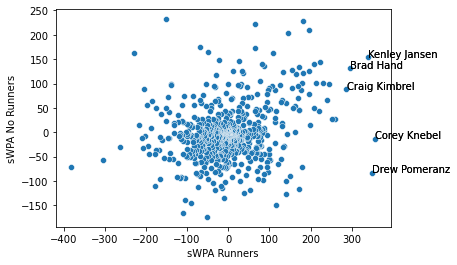

In [21]:
sns.scatterplot(data=df, x='sWPA Runners', y='sWPA No Runners')

# label 5 best pitchers with runners on
temp = df.sort_values(by="sWPA Runners", ascending=False)
for i in range(5):
    plt.text(temp.loc[i, "sWPA Runners"]+0.2,
             temp.loc[i, "sWPA No Runners"]+0.2,
             temp.loc[i, "player"])
    
# 5 best pitchers with runners off
temp = df.sort_values(by="sWPA No Runners", ascending=False)
for i in range(5):
    plt.text(temp.loc[i, "sWPA Runners"]+0.2,
             temp.loc[i, "sWPA No Runners"]+0.2,
             temp.loc[i, "player"])

plt.show()

Time for some more EDA. Two entries had a NULL pitch count. Rather than figure that out, lets just drop them.

In [22]:
pbp[pbp['pitch_count'] == "NULL"]

,season,boxscore_link,inning,score,out,RoB,pitches,pitch_count,pitch_sequence,run_or_out,...,pitcher,link_to_pitcher,wWPA,wWE,description,pitching_team,pitching_team_wins,WPA,cum_pitch_count,runners_on
37228,2017,/boxes/SEA/SEA201706100.shtml,t8,3-2,2,1--,NaN,NULL,NULL,,...,Tony Zych,/players/z/zychto01.shtml,1,73,Bautista Steals 2B,SEA,False,-1,19.0,True
74582,2017,/boxes/MIN/MIN201709120.shtml,t9,0-16,2,1--,NaN,NULL,NULL,,...,Gabriel Moya,/players/m/moyaga01.shtml,0,100,Balk; Myers to 2B,MIN,True,0,10.0,True


In [23]:
pbp = pbp[pbp['pitch_count']  != "NULL"]

Some more EDA: check to see the average WPA for at bats with a particular pitch count. <br>
Three pitchers counts: 0-2, 1-2, 2-2. All of them significantly pro pitcher.<br>
0-1 is basically a wash.<br>
3-2 slightly favors the hitter.<br>
3-1 and 3-0 the wheels fall off for the pitcher

In [24]:
pbp.groupby('pitch_count')['WPA'].mean().sort_values(ascending=False)

pitch_count
(0-2)    0.994953
(1-2)    0.933716
(2-2)    0.801506
(0-1)   -0.280787
(3-2)   -0.411173
(1-1)   -0.440644
(0-0)   -0.511062
(1-0)   -0.541189
(2-1)   -0.593308
(2-0)   -0.708264
(3-1)   -1.605602
(3-0)   -1.922855
Name: WPA, dtype: float64

EDA: Does number of pitches/AB have any impact?

In [25]:
pbp.groupby('pitches')['WPA'].mean()

pitches
1.0    -0.509477
2.0    -0.391958
3.0     0.101966
4.0     0.278662
5.0     0.192997
6.0     0.095639
7.0    -0.164360
8.0    -0.256732
9.0    -0.336735
10.0   -0.151697
11.0    0.497041
12.0   -1.347222
13.0    1.000000
14.0   -4.222222
15.0   -2.333333
17.0    1.000000
Name: WPA, dtype: float64

1 pitch decidedly pro batter. 2 a little bit. 3 4 5 6 very very very slighly pro pitcher. anything more is either pro batter or a weird fluke outlier

In [26]:
(pbp.groupby('pitches')['WPA'].mean() * \
 pbp.groupby('pitches')['WPA'].count()).sort_values(ascending=False)

pitches
4.0      9822.0
5.0      6151.0
3.0      3500.0
6.0      2114.0
11.0       84.0
13.0       21.0
17.0        1.0
15.0       -7.0
14.0      -38.0
10.0      -76.0
12.0      -97.0
9.0      -495.0
8.0     -1001.0
7.0     -1544.0
1.0    -11021.0
2.0    -11580.0
Name: WPA, dtype: float64

More EDA: cumulative pitch count and WAP

<AxesSubplot:xlabel='cum_pitch_count', ylabel='WPA'>

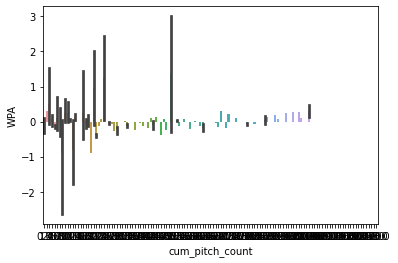

In [27]:
sns.barplot(x=pbp['cum_pitch_count'], y=pbp.groupby('cum_pitch_count')['WPA'].mean())

Based on the above chart the cumulative pitch count is actually all over the place. I do not believe it will make much of an impact. UNLESS theres some sort of "this pitcher starts to drop off after X amount of pitches" kind of deal.

Create some dummy variables. pitch count and runners on base situations.

In [28]:
pbp = pd.get_dummies(pbp, prefix='pc', columns=['pitch_count'])
pbp = pd.get_dummies(pbp, prefix='rob', columns=['RoB'])

Time to import some pitcher and hitter stats. First, lets look at batter stats. Sum it up by looking at WAR. At first, looked at whole season WAR to see if there was any corellation. Looking at the whole season WAR during an at bat would constitute data leakage, but it ended up that the batter's WAR did not have any corelation with WPA for the at bat so I ended up not using the batter's WAR or the pitcher's ERA.

In [31]:
# oWAR -> offensive wins above replacement
sql = """SELECT player_link, oWAR
FROM player_batter_values
WHERE season={};""".format(season)

bv = db.select_to_df(sql)

pbp = pbp.merge(bv, 'left', left_on='link_to_batter',
          right_on='player_link')

Checking for corelation between oWAR and WPA

In [32]:
pbp = pbp[pbp['oWAR']  != ""]
pbp['oWAR'] = pbp['oWAR'].astype('float')

Totally horizontal trend line.

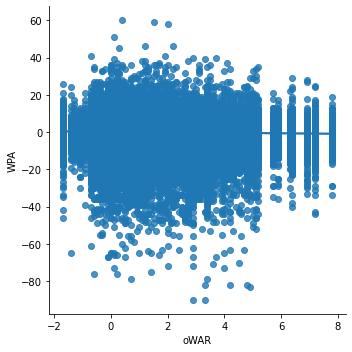

In [33]:
sns.lmplot(data=pbp, x='oWAR', y='WPA')

Feature engineer a score difference column. This will be significant because tighter score margins will mean more significant at bats. First, need to figure out who the home team is for each at bat.

In [34]:
def get_home_team(row):
    # returns true if the pitching team is the home team.
    # the row is an entry from pbp
    tag = games[
        (games['boxscore_link'] == row['boxscore_link']) &
        (games['team'] == row['pitching_team'])
    ]['home_or_vs'].values
    if tag == '': 
        return True
    return False

In [35]:
pbp['pitching_team_home'] = pbp.apply(get_home_team, axis=1)

In [36]:
pbp['pitching_team_home'].value_counts()

True     105226
False    101581
Name: pitching_team_home, dtype: int64

In [37]:
def get_score_difference(row):
    # - score means pitching team losing.
    m = re.match(r'(\d*)-(\d*)', row['score'])
    if row['pitching_team_home']:
        batting_score = m.group(1)
        pitching_score = m.group(2)
    else:
        pitching_score = m.group(1)
        batting_score = m.group(2)
    return int(pitching_score) - int(batting_score)

In [38]:
pbp['score_difference'] = pbp.apply(get_score_difference, axis=1)

Our target variable is WPA so lets look at its distribution.<br>
The top 25% is 2 WPA and above. The bottom 25% is -2 and below.


<AxesSubplot:xlabel='WPA'>

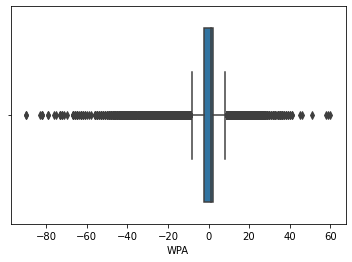

In [29]:
sns.boxplot(x=pbp['WPA'])

In [30]:
pbp['WPA'].describe()

count    191194.000000
mean         -0.024216
std           5.330774
min         -90.000000
25%          -2.000000
50%           1.000000
75%           2.000000
max          60.000000
Name: WPA, dtype: float64

Lets call at bats where $|WPA| > 2$ 'significant'. Then lets look for $|WPA| > 10$.<br>
First, heres an overview of our data.

In [39]:
pbp.head(3).T

,0,1,2
season,2017,2017,2017
boxscore_link,/boxes/TBA/TBA201704020.shtml,/boxes/TBA/TBA201704020.shtml,/boxes/TBA/TBA201704020.shtml
inning,t1,t1,t1
score,0-0,0-0,0-0
out,0,1,2
pitches,6.0,1.0,5.0
pitch_sequence,BCBCFX,X,CBBBB
run_or_out,O,O,
batting_team,NYY,NYY,NYY
batter,Brett Gardner,Gary Sanchez,Greg Bird


In [40]:
pbp['significant'] = (abs(pbp['WPA']) >= 2)
pbp = pbp.dropna()

In [41]:
# drop columns that are useless or may cause data leakage.
to_drop = ['season', 'boxscore_link', 'inning', 'score', 'pitch_sequence', 
          'run_or_out', 'batting_team', 'batter', 'link_to_batter',
          'pitcher', 'link_to_pitcher', 'wWPA', 'wWE', 'description',
          'pitching_team', 'pitching_team_wins', 'WPA', 'player_link', 'significant']
X = set(pbp.columns)
X = list(X.difference(to_drop))
Y = np.array(['significant'])

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
xtrain, xtest, ytrain, ytest = train_test_split(pbp[X], pbp[Y], random_state=0)

In [45]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(xtrain, ytrain)

/tmp/ipykernel_12413/560660069.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(xtrain, ytrain)


RandomForestClassifier(random_state=0)

In [47]:
forest.score(xtrain, ytrain)

0.9978291207939215

In [48]:
forest.score(xtest, ytest)

0.9045365370224299

Pretty good accuracy. But its likely that its just looking at score difference and saying that all blowouts are for sure going to have $|WPA| < 2$

In [62]:
# yeah tighter margins have much higher impact.
pbp.groupby('score_difference')['WPA'].mean().abs().sort_values(ascending=False).head(10)

score_difference
 0    0.240371
 1    0.228994
 2    0.143030
-2    0.073747
 4    0.069436
 3    0.063641
-4    0.046512
 7    0.041185
 8    0.032982
-7    0.027318
Name: WPA, dtype: float64

Now try $|WPA|$ > 10. Still very good results.

In [63]:
pbp['significant'] = (abs(pbp['WPA']) >= 10)
pbp = pbp.dropna()

In [64]:
# drop columns that are useless or may cause data leakage.
to_drop = ['season', 'boxscore_link', 'inning', 'score', 'pitch_sequence', 
          'run_or_out', 'batting_team', 'batter', 'link_to_batter',
          'pitcher', 'link_to_pitcher', 'wWPA', 'wWE', 'description',
          'pitching_team', 'pitching_team_wins', 'WPA', 'player_link', 'significant']
X = set(pbp.columns)
X = list(X.difference(to_drop))
Y = np.array(['significant'])

In [65]:
xtrain, xtest, ytrain, ytest = train_test_split(pbp[X], pbp[Y], random_state=0)

In [66]:
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(xtrain, ytrain)

/tmp/ipykernel_12413/560660069.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(xtrain, ytrain)


RandomForestClassifier(random_state=0)

In [67]:
forest.score(xtrain, ytrain)

0.9972156114530732

In [68]:
forest.score(xtest, ytest)

0.9371195113565115

I very briefly attempted to do a regressor to predict actual values of WPA. Did not do anyfeature selection or any CVGridSearches, only a brief attempt. The model overfit pretty poorly. The train data had an R^2 of .83 while the test data had a score of almost 0.